# Get clinical trial info for drugs in Tahoe dataset

In [2]:
# Autoreload extension
%load_ext autoreload
%autoreload 2


In [3]:
# !pip install huggingface
# !pip install datasets

In [4]:
import requests
import pandas as pd
import json
import time
from typing import List, Dict, Any, Union, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset

ds = load_dataset("tahoebio/Tahoe-100M", "drug_metadata")

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Convert the dataset to a pandas DataFrame and display it
drug_metadata = ds["train"].to_pandas()
drug_metadata.head()

,drug,targets,moa-broad,moa-fine,human-approved,clinical-trials,gpt-notes-approval,canonical_smiles,pubchem_cid
0,Talc,None,unclear,unclear,yes,yes,Talc used in pharma and cosmetics; safety unde...,[OH-].[OH-].[O-][Si]12O[Si]3(O[Si](O1)(O[Si](O...,165411828.0
1,Bortezomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma and mantle cell ...,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,387447.0
2,Ixazomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma treatment.,B(C(CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)Cl)(O)O,25183872.0
3,Ixazomib citrate,"PSMB1, PSMB2, PSMB5",inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma treatment as par...,B1(OC(=O)C(O1)(CC(=O)O)CC(=O)O)C(CC(C)C)NC(=O)...,56844015.0
4,Lactate (calcium),None,unclear,unclear,yes,yes,"Used in medical settings, but not specifically...",C.CC(C(=O)[O-])O.[Ca+2],168311648.0


In [14]:
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid'].astype(str)
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid_str'].str.split('\\.0').str[0]
all_pubchem_ids = drug_metadata['pubchem_cid_str'][drug_metadata['pubchem_cid_str'] != 'nan'].unique().tolist()

In [55]:
from drug_trials_extractor import DrugTrialExtractor

In [56]:
# Create an instance of the DrugTrialExtractor
extractor = DrugTrialExtractor()

In [65]:
results = extractor.process_multiple_drugs(all_pubchem_ids, max_results_per_drug=500)
output_files = extractor.save_results_to_csv(results, output_prefix="tahoe_drugs")

Processing PubChem ID: 165411828
Searching ClinicalTrials.gov for common name: STERITALC
Searching ClinicalTrials.gov for synonym: STERITALC
Processing PubChem ID: 387447
Searching ClinicalTrials.gov for common name: DPBA
Searching ClinicalTrials.gov for synonym: Bortezomib
Processing PubChem ID: 25183872
Searching ClinicalTrials.gov for common name: Ixazomib
Searching ClinicalTrials.gov for synonym: Ixazomib
Searching ClinicalTrials.gov for synonym: MLN 2238
Searching ClinicalTrials.gov for synonym: 71050168A2
Processing PubChem ID: 56844015
Searching ClinicalTrials.gov for common name: NINLARO
Searching ClinicalTrials.gov for synonym: NINLARO
Searching ClinicalTrials.gov for synonym: mln9708
Searching ClinicalTrials.gov for synonym: 46CWK97Z3K
Processing PubChem ID: 168311648
Searching ClinicalTrials.gov for common name: Lactate (calcium)
Processing PubChem ID: 168312271
Searching ClinicalTrials.gov for common name: Bisoprolol (hemifumarate)
Processing PubChem ID: 444972
Searching Cl

In [7]:
trials_df = pd.read_csv('tahoe_drugs_clinical_trials.csv')

<Axes: xlabel='pubchem_id', ylabel='conditions'>

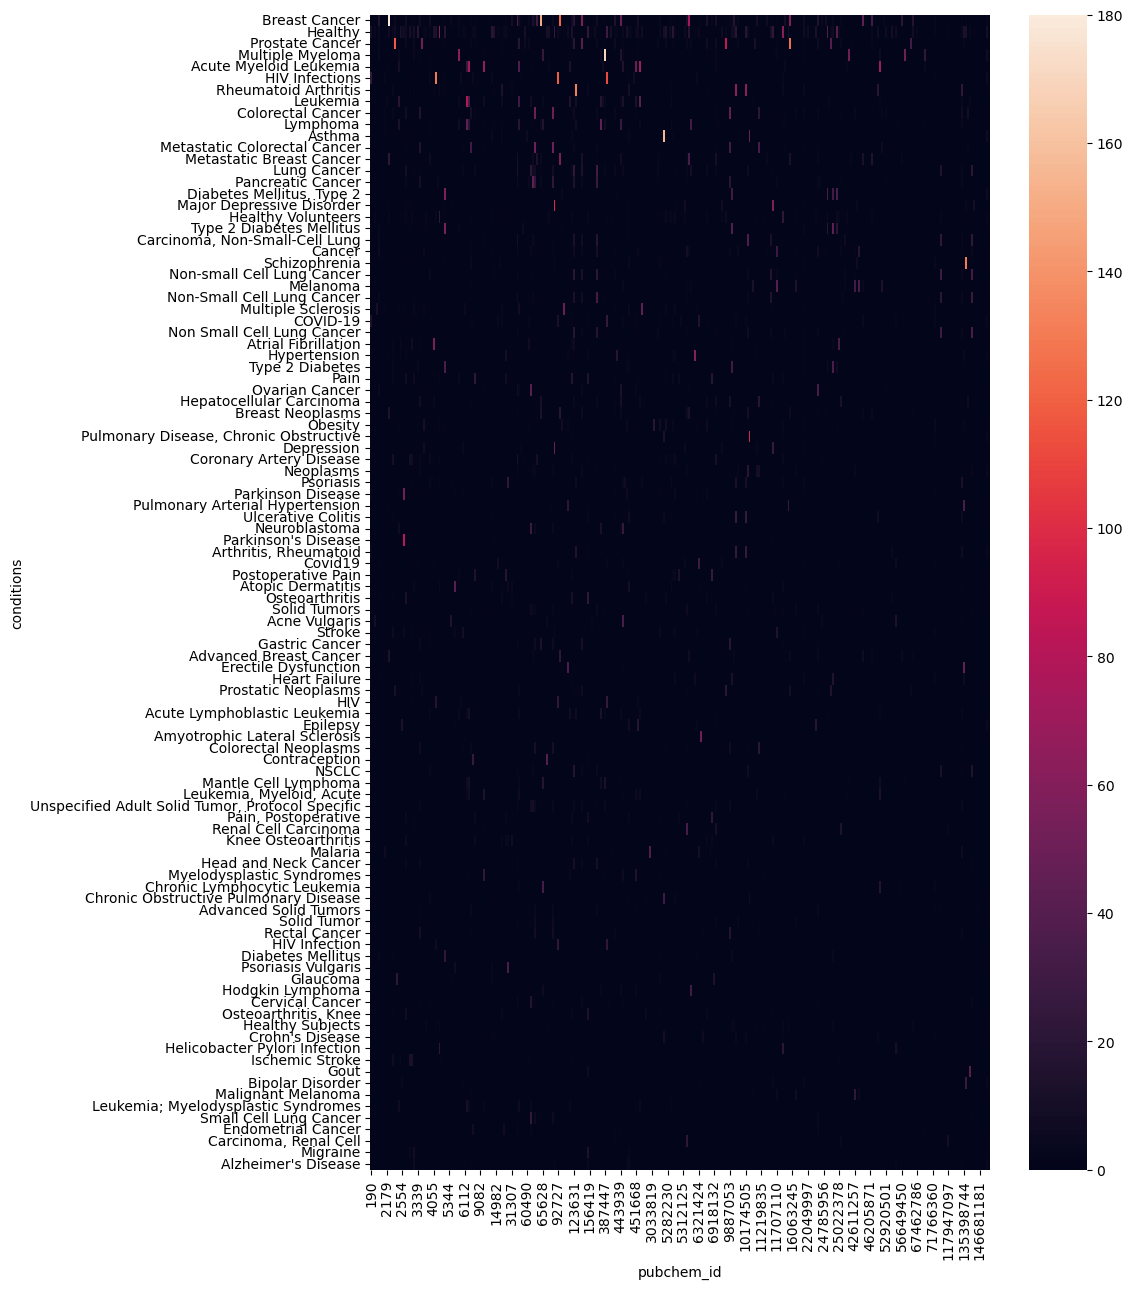

In [8]:
# Count the number of conditions in trials for each drug
condition_counts = trials_df.groupby(['pubchem_id', 'conditions']).size().reset_index()
condition_counts = condition_counts.pivot(index='conditions', columns='pubchem_id', values=0).fillna(0)
plt.figure(figsize=(10,15))
sns.heatmap(condition_counts.loc[condition_counts.sum(1).sort_values(ascending=False)[0:100].index], yticklabels=True)

In [19]:
len(all_pubchem_ids)

376

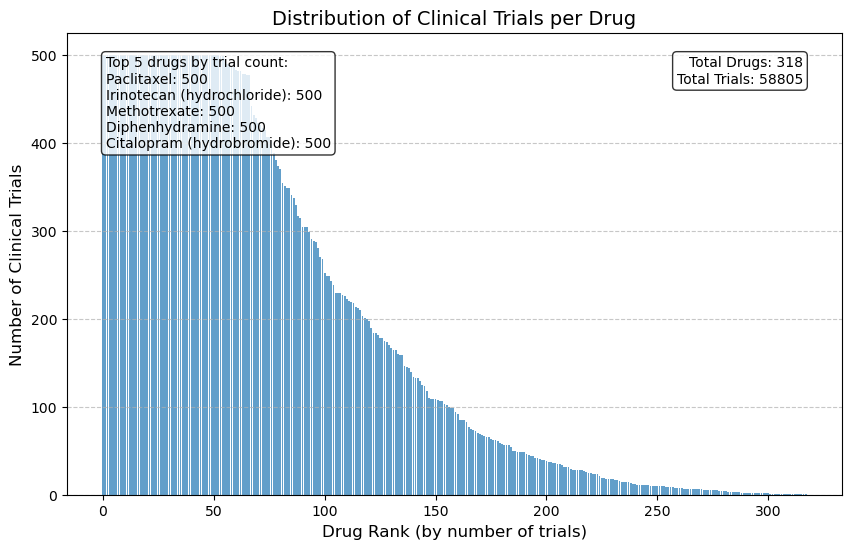

In [27]:
# Create a more informative plot of trials per drug
trial_counts = trials_df['pubchem_id'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(len(trial_counts)), trial_counts.values, alpha=0.7)
plt.xlabel('Drug Rank (by number of trials)', fontsize=12)
plt.ylabel('Number of Clinical Trials', fontsize=12)
plt.title('Distribution of Clinical Trials per Drug', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text showing total drugs and trials
plt.text(0.95, 0.95, f'Total Drugs: {len(trial_counts)}\nTotal Trials: {len(trials_df)}', 
         transform=plt.gca().transAxes, ha='right', va='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Show the top 5 drugs with most trials
if len(trial_counts) >= 5:
    top_drugs = trial_counts.head(5)
    top_drug_ids = top_drugs.index.tolist()
    top_drug_names = [drug_metadata.loc[drug_metadata['pubchem_cid_str'] == str(drug_id), 'drug'].values[0] 
                      if str(drug_id) in drug_metadata['pubchem_cid_str'].values else f"ID: {drug_id}" 
                      for drug_id in top_drug_ids]
    
    plt.text(0.05, 0.95, 'Top 5 drugs by trial count:\n' + '\n'.join([f"{name}: {count}" for name, count in zip(top_drug_names, top_drugs)]),
             transform=plt.gca().transAxes, ha='left', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

## To check one entry

In [63]:
import requests
import json
import time

def examine_study_structure(pubchem_id):
    """
    Examine the full field structure for clinical trials related to a drug with given PubChem ID
    """
    print(f"Examining study structure for PubChem ID: {pubchem_id}")
    
    # Get drug name from PubChem
    pubchem_base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
    synonyms_url = f"{pubchem_base_url}/compound/cid/{pubchem_id}/synonyms/JSON"
    
    try:
        synonyms_response = requests.get(synonyms_url)
        if synonyms_response.status_code != 200:
            print(f"Error retrieving synonyms: {synonyms_response.status_code}")
            return
            
        synonyms_data = synonyms_response.json()
        synonyms = synonyms_data.get("InformationList", {}).get("Information", [{}])[0].get("Synonym", [])
        
        # Try to find a short, drug-like name
        drug_name = None
        for syn in sorted(synonyms, key=len):
            if 3 < len(syn) < 20 and syn[0].isupper() and syn.isalpha():
                drug_name = syn
                break
                
        if not drug_name and synonyms:
            drug_name = synonyms[0]
            
        print(f"Using drug name: {drug_name}")
            
        # Search clinical trials
        clinicaltrials_api_url = "https://clinicaltrials.gov/api/v2/studies"
        params = {
            "query.term": drug_name,
            "pageSize": 1  # Just get one study to examine structure
        }
        
        response = requests.get(clinicaltrials_api_url, params=params)
        
        if response.status_code != 200:
            print(f"Error searching ClinicalTrials.gov: {response.status_code}")
            return
            
        data = response.json()
        studies = data.get("studies", [])
        
        if not studies:
            print("No studies found")
            return
            
        # Print the structure of the first study
        study = studies[0]
        
        # Print key paths
        protocol = study.get("protocolSection", {})
        
        print("\nStudy ID:")
        print(protocol.get("identificationModule", {}).get("nctId", "Not found"))
        
        print("\nPhase Module Structure:")
        print(json.dumps(protocol.get("phaseModule", {}), indent=2))
        
        print("\nFull Protocol Section Structure (keys only):")
        print_nested_keys(protocol)
        
        # Optionally dump the full structure to a file for detailed examination
        with open(f"study_structure_{pubchem_id}.json", "w") as f:
            json.dump(study, f, indent=2)
        print(f"\nFull structure saved to study_structure_{pubchem_id}.json")
        
    except Exception as e:
        print(f"Error examining study structure: {e}")
        
def print_nested_keys(obj, prefix=""):
    """Print the keys of a nested dictionary with indentation"""
    if isinstance(obj, dict):
        for key in obj.keys():
            print(f"{prefix}{key}")
            if isinstance(obj[key], (dict, list)) and obj[key]:
                print_nested_keys(obj[key], prefix + "  ")
    elif isinstance(obj, list) and obj:
        print(f"{prefix}[list with {len(obj)} items]")
        if len(obj) > 0 and isinstance(obj[0], dict):
            print_nested_keys(obj[0], prefix + "  ")

# Example usage
pubchem_id = "165411828"  # Ixazomib
examine_study_structure(pubchem_id)

Examining study structure for PubChem ID: 165411828
Using drug name: STERITALC

Study ID:
NCT04010565

Phase Module Structure:
{}

Full Protocol Section Structure (keys only):
identificationModule
  nctId
  orgStudyIdInfo
    id
  organization
    fullName
    class
  briefTitle
  officialTitle
  acronym
statusModule
  statusVerifiedDate
  overallStatus
  expandedAccessInfo
    hasExpandedAccess
  startDateStruct
    date
    type
  primaryCompletionDateStruct
    date
    type
  completionDateStruct
    date
    type
  studyFirstSubmitDate
  studyFirstSubmitQcDate
  studyFirstPostDateStruct
    date
    type
  lastUpdateSubmitDate
  lastUpdatePostDateStruct
    date
    type
sponsorCollaboratorsModule
  responsibleParty
    type
  leadSponsor
    name
    class
  collaborators
    [list with 4 items]
      name
      class
oversightModule
  isFdaRegulatedDrug
  isFdaRegulatedDevice
descriptionModule
  briefSummary
  detailedDescription
conditionsModule
  conditions
    [list with 1 it